### Instrucciones

El conjunto de datos a explorar es un set de datos de recaudaciones de
películas de cine. En el siguiente enlace se pueden obtener los datos, así
como el detalle del contenido de estos: Movie Industry | Kaggle 

* Quedan excluidas del desafío las variables: director, star y writer

#### Cuestiones planteadas

En la presentación se espera que des recomendaciones de qué tipo de
películas debería hacer una productora de cine que quiere maximizar el
beneficio de sus producciones. A modo de ejemplo, estas son algunas de las
preguntas que se puede plantear la compañía en este sentido:

• ¿En qué género debería enfocarme?

• ¿Qué tan importante es producir una buena película (rating IMDB alto)
para obtener muchos ingresos?

• ¿Es mejor producir una película para todos los públicos? ¿O una dirigida
sólo al público adulto?

• ...

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import statsmodels.formula.api as smf

In [2]:
# Reading data

raw_data = pd.DataFrame(pd.read_csv('../raw_data/movies.csv', encoding = 'iso-8859-1'))

In [3]:
raw_data.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [4]:
# Dropping director, star and writer
data = raw_data.drop(columns =['director', 'star', 'writer'])


In [5]:
data.head()

,budget,company,country,genre,gross,name,rating,released,runtime,score,votes,year
0,8000000.0,Columbia Pictures Corporation,USA,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,299174,1986
1,6000000.0,Paramount Pictures,USA,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,264740,1986
2,15000000.0,Paramount Pictures,USA,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,236909,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,540152,1986
4,9000000.0,Walt Disney Pictures,USA,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,36636,1986


### Data Cleaning

In [6]:
#Checking for duplicates

len(data) # Check number of rows before removing duplicates
data = data.drop_duplicates() # Remove duplicates
len(data)# Check new number of rows

6820

In [7]:
# Checking for null values 

data.isnull().sum().sort_values(ascending=False)/len(data) #NaN percentage for each column

budget      0.0
company     0.0
country     0.0
genre       0.0
gross       0.0
name        0.0
rating      0.0
released    0.0
runtime     0.0
score       0.0
votes       0.0
year        0.0
dtype: float64

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version

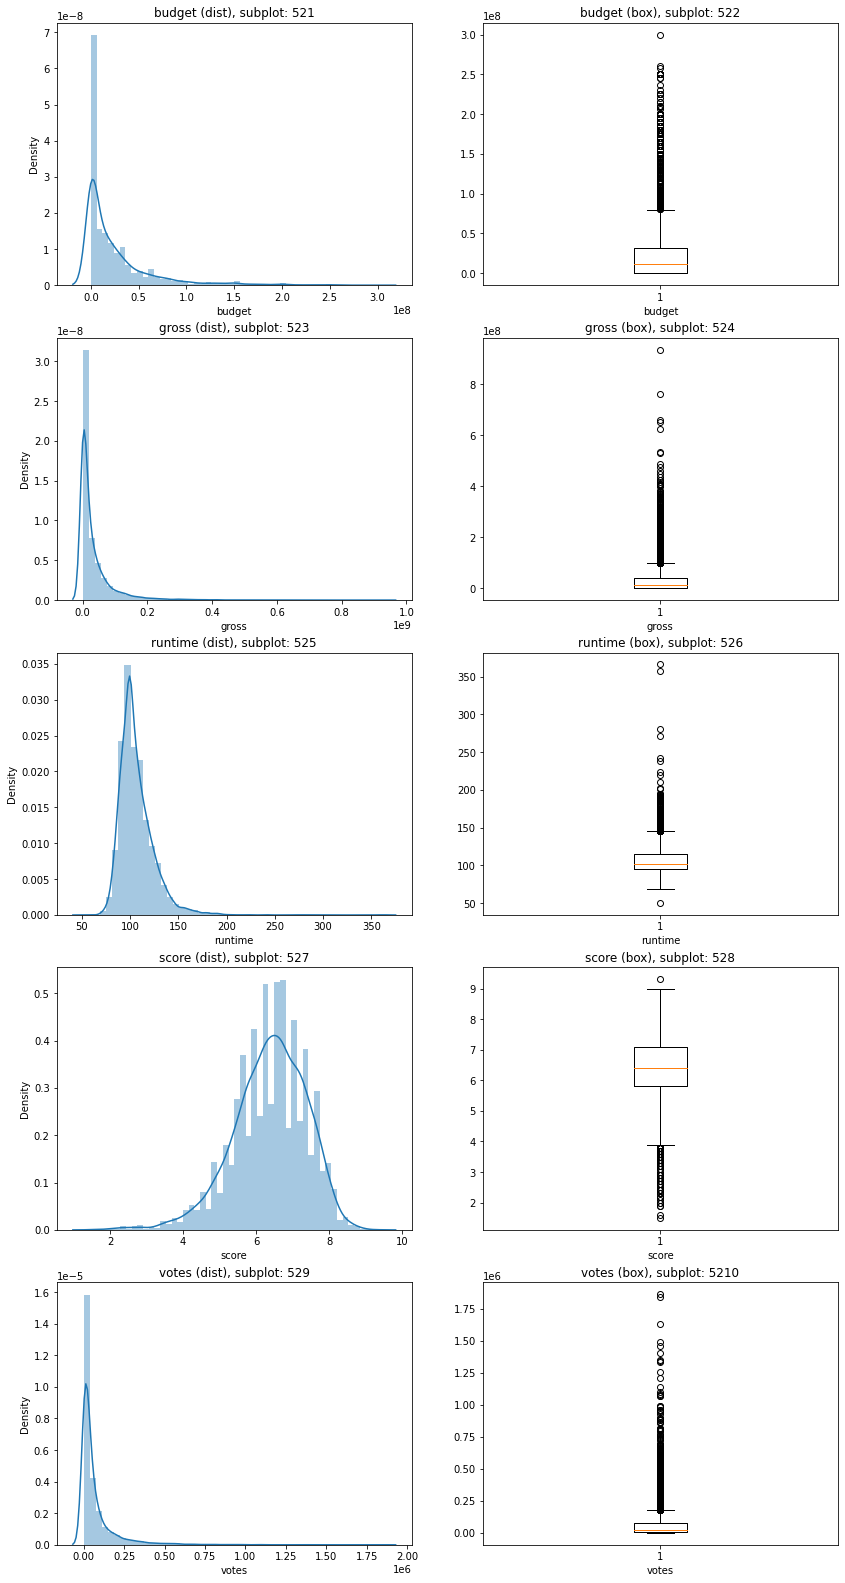

In [8]:
# Plotting and checking for false outliers

#  Numerical Data
data_NUM = ['budget', 'gross', 'runtime', 'score', 'votes']

#  plot Numerical Data
a = 5  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,28))

for i in data_NUM:
    plt.subplot(a, b, c)
    plt.title('{} (dist), subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.distplot(data[i])
    c = c + 1

    plt.subplot(a, b, c)
    plt.title('{} (box), subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    plt.boxplot(x = data[i])
    c = c + 1

In [9]:
# Counting 0 values in budget

data['budget'].value_counts().sort_index(ascending=True)

0.0            2182
6000.0            1
7000.0            2
15000.0           2
20000.0           1
               ... 
245000000.0       2
250000000.0       8
258000000.0       1
260000000.0       1
300000000.0       1
Name: budget, Length: 351, dtype: int64

In [10]:
# Creating a second data frame to evaluate profit (revenue - cost)

# Keeping rows that have a positive budget, since profit without budget would be just revenue.

data_profit = pd.DataFrame(data[data['budget'] > 0])

# Creating profit column = gross - budget

data_profit['profit'] = data_profit['gross'] - data_profit['budget']

data_profit

,budget,company,country,genre,gross,name,rating,released,runtime,score,votes,year,profit
0,8000000.0,Columbia Pictures Corporation,USA,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,299174,1986,44287414.0
1,6000000.0,Paramount Pictures,USA,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,264740,1986,64136369.0
2,15000000.0,Paramount Pictures,USA,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,236909,1986,164800601.0
3,18500000.0,Twentieth Century Fox Film Corporation,USA,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,540152,1986,66660248.0
4,9000000.0,Walt Disney Pictures,USA,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,36636,1986,9564613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6808,3000000.0,Westerly Films,Ireland,Comedy,14013564.0,Love & Friendship,PG,2016-06-03,90,6.5,17862,2016,11013564.0
6809,3800000.0,Sycamore Pictures,USA,Comedy,1016872.0,The Hollars,PG-13,2016-08-26,88,6.5,7227,2016,-2783128.0
6811,8500000.0,CBS Films,USA,Animation,19985196.0,Middle School: The Worst Years of My Life,PG,2016-10-07,92,6.1,4556,2016,11485196.0
6814,20000000.0,LD Entertainment,USA,Action,36874745.0,Risen,PG-13,2016-02-19,107,6.3,19084,2016,16874745.0


In [11]:
# Creating high_score column (Score >= 7.5)

def high_score(row):
    if row['score'] >= 7.5:
        return 1
    else:
        return 0 

data['high_score'] = data.apply (lambda row: high_score(row), axis=1)

# Replicate process for profit dataframe
data_profit['high_score'] = data_profit.apply (lambda row: high_score(row), axis=1) 

In [12]:
data['high_score'].value_counts()

0    5888
1     932
Name: high_score, dtype: int64

In [13]:
# Scaling numeric independent variables 

# Defining numeric independent variables
data_NUM_X = ['budget', 'runtime', 'score', 'votes']

scaler = MinMaxScaler() # Instanciate MinMaxScaler


for i in data_NUM_X:
    scaler.fit(data[[i]]) # Fit scaler to data
    data[i] = scaler.transform(data[[i]]) # Use scaler to transform data
    # Replicate process for profit dataframe
    scaler.fit(data_profit[[i]]) # Fit scaler to data
    data_profit[i] = scaler.transform(data_profit[[i]]) # Use scaler to transform data



### Feature Engineering

In [14]:
# Checking number of unique values for categorical variables

data_CAT = ['company', 'country', 'genre', 'rating']
for i in data_CAT:
    print(f'{i} has {data[i].nunique()} unique values.')


company has 2179 unique values.
country has 57 unique values.
genre has 17 unique values.
rating has 13 unique values.


In [15]:
# Encoding Genre 

genre_encoding = pd.DataFrame(data[['genre']])
genre_encoding = pd.get_dummies(genre_encoding)
# Replicate process for profit dataframe
genre_encoding_profit = pd.DataFrame(data_profit[['genre']])
genre_encoding_profit = pd.get_dummies(genre_encoding_profit)

# Encoding Rating

rating_encoding = pd.DataFrame(data[['rating']])
rating_encoding = pd.get_dummies(rating_encoding)
# Replicate process for profit dataframe
rating_encoding_profit = pd.DataFrame(data_profit[['rating']])
rating_encoding_profit = pd.get_dummies(rating_encoding_profit)

In [16]:
rating_encoding

,rating_B,rating_B15,rating_G,rating_NC-17,rating_NOT RATED,rating_Not specified,rating_PG,rating_PG-13,rating_R,rating_TV-14,rating_TV-MA,rating_TV-PG,rating_UNRATED
0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,0,0,0,0,0,0,0,0,1,0,0,0,0
6816,0,0,0,0,0,0,0,1,0,0,0,0,0
6817,0,0,0,0,0,0,0,0,1,0,0,0,0
6818,0,0,0,0,0,0,0,0,1,0,0,0,0


In [17]:
# Create adult_movie column

def adult_rated(row):
    if row['rating'] == 'R':
        return 1
    elif row['rating'] == 'NC-17':
        return 1
    elif row['rating'] == 'TV-MA':
        return 1
    else:
        return 0 

data['adult_movie'] = data.apply (lambda row: adult_rated(row), axis=1)  

# Replicate process for profit dataframe

data_profit['adult_movie'] = data_profit.apply (lambda row: adult_rated(row), axis=1) 

In [18]:
# Create general_movie column
def general_rated(row):
    if row['rating'] == 'G':
        return 1
    else:
        return 0 

data['general_movie'] = data.apply (lambda row: general_rated(row), axis=1)

# Replicate process for profit dataframe
data_profit['general_movie'] = data_profit.apply (lambda row: general_rated(row), axis=1) 

In [19]:
# Encoding company

company_encoding = pd.DataFrame(data[['company']])

# Creating list with 25 most frequent companies

company_encoding.company.value_counts().sort_values(ascending=False).head(25)
top_25_companies = [x for x in company_encoding.company.value_counts().sort_values(ascending=False).head(25).index]

# Creating binary columns for top 25 companies
for i in top_25_companies:
    company_encoding[i] = np.where(company_encoding.company == i, 1, 0)

In [20]:
# Encoding countries

country_encoding = pd.DataFrame(data[['country']])

# Creating list with 15 most frequent countries

country_encoding.country.value_counts().sort_values(ascending=False).head(15)
top_15_countries = [x for x in country_encoding.country.value_counts().sort_values(ascending=False).head(15).index]

# Creating binary columns for top 15 countries
for i in top_15_countries:
    country_encoding[i] = np.where(country_encoding.country == i, 1, 0)

### Feature Selection

In [21]:
# Evaluating Pearson Correlation between features

corr = data.corr() # Create correlation matrix
corr

,budget,gross,runtime,score,votes,year,high_score,adult_movie,general_movie
budget,1.000000,0.712196,0.268226,0.042145,0.503924,0.291009,0.018257,-0.243810,0.051912
gross,0.712196,1.000000,0.224579,0.165693,0.662457,0.191548,0.137533,-0.235499,0.074646
runtime,0.268226,0.224579,1.000000,0.395343,0.317399,0.087639,0.309009,0.042040,-0.119022
score,0.042145,0.165693,0.395343,1.000000,0.393607,0.105276,0.567589,0.079061,0.009351
votes,0.503924,0.662457,0.317399,0.393607,1.000000,0.229304,0.402893,-0.034908,0.005473
year,0.291009,0.191548,0.087639,0.105276,0.229304,1.000000,0.026286,-0.040297,-0.049677
high_score,0.018257,0.137533,0.309009,0.567589,0.402893,0.026286,1.000000,0.012223,0.011498
adult_movie,-0.243810,-0.235499,0.042040,0.079061,-0.034908,-0.040297,0.012223,1.000000,-0.148640
general_movie,0.051912,0.074646,-0.119022,0.009351,0.005473,-0.049677,0.011498,-0.148640,1.000000


In [22]:
# Evaluating R Squared
corr**2

,budget,gross,runtime,score,votes,year,high_score,adult_movie,general_movie
budget,1.000000,0.507222,0.071945,0.001776,0.253939,0.084686,0.000333,0.059444,0.002695
gross,0.507222,1.000000,0.050436,0.027454,0.438849,0.036690,0.018915,0.055460,0.005572
runtime,0.071945,0.050436,1.000000,0.156296,0.100742,0.007681,0.095487,0.001767,0.014166
score,0.001776,0.027454,0.156296,1.000000,0.154927,0.011083,0.322158,0.006251,0.000087
votes,0.253939,0.438849,0.100742,0.154927,1.000000,0.052580,0.162323,0.001219,0.000030
year,0.084686,0.036690,0.007681,0.011083,0.052580,1.000000,0.000691,0.001624,0.002468
high_score,0.000333,0.018915,0.095487,0.322158,0.162323,0.000691,1.000000,0.000149,0.000132
adult_movie,0.059444,0.055460,0.001767,0.006251,0.001219,0.001624,0.000149,1.000000,0.022094
general_movie,0.002695,0.005572,0.014166,0.000087,0.000030,0.002468,0.000132,0.022094,1.000000


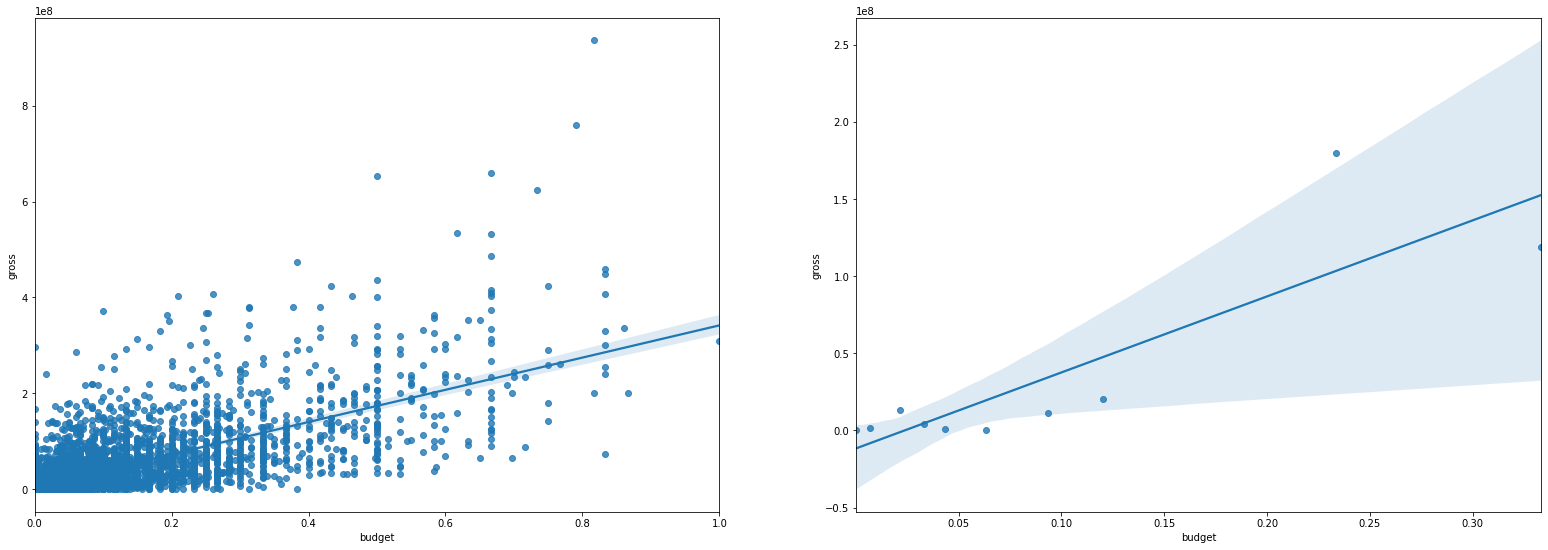

In [23]:
# Plotting relationship between gross and budget

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='budget', y='gross', data=data, ci=95)
plt.subplot(2,2,2)
sns.regplot(x='budget', y='gross', data=data.sample(10, random_state=6), ci=95);

In [24]:
# Ranking features by correlation

corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(20)

,feature_1,feature_2,correlation
9,gross,budget,0.712196
1,budget,gross,0.712196
13,gross,votes,0.662457
37,votes,gross,0.662457
33,score,high_score,0.567589
57,high_score,score,0.567589
36,votes,budget,0.503924
4,budget,votes,0.503924
42,votes,high_score,0.402893
58,high_score,votes,0.402893


In [25]:
corr_df.tail(20)

,feature_1,feature_2,correlation
78,general_movie,high_score,0.011498
62,high_score,general_movie,0.011498
75,general_movie,score,0.009351
35,score,general_movie,0.009351
76,general_movie,votes,0.005473
44,votes,general_movie,0.005473
67,adult_movie,votes,-0.034908
43,votes,adult_movie,-0.034908
52,year,adult_movie,-0.040297
68,adult_movie,year,-0.040297


In [26]:
# Evaluating Pearson Correlation between features for profit dataframe

corr_profit = data_profit.corr() # Create correlation matrix
corr_profit

,budget,gross,runtime,score,votes,year,profit,high_score,adult_movie,general_movie
budget,1.000000,0.680033,0.313064,0.073579,0.451467,0.259835,0.104606,0.045713,-0.306308,0.070656
gross,0.680033,1.000000,0.253273,0.229552,0.642904,0.167492,0.800295,0.201880,-0.269143,0.088773
runtime,0.313064,0.253273,1.000000,0.417031,0.359817,0.047811,0.087520,0.323162,0.055381,-0.138929
score,0.073579,0.229552,0.417031,1.000000,0.470648,0.061479,0.251199,0.561325,0.127904,0.018308
votes,0.451467,0.642904,0.359817,0.470648,1.000000,0.184096,0.502842,0.499106,-0.038681,0.011457
year,0.259835,0.167492,0.047811,0.061479,0.184096,1.000000,0.014695,0.001203,-0.084035,-0.038766
profit,0.104606,0.800295,0.087520,0.251199,0.502842,0.014695,1.000000,0.236453,-0.114572,0.062631
high_score,0.045713,0.201880,0.323162,0.561325,0.499106,0.001203,0.236453,1.000000,0.058702,0.022508
adult_movie,-0.306308,-0.269143,0.055381,0.127904,-0.038681,-0.084035,-0.114572,0.058702,1.000000,-0.144466
general_movie,0.070656,0.088773,-0.138929,0.018308,0.011457,-0.038766,0.062631,0.022508,-0.144466,1.000000


In [27]:
# Evaluating R Squared for profit dataframe
corr_profit**2

,budget,gross,runtime,score,votes,year,profit,high_score,adult_movie,general_movie
budget,1.000000,0.462444,0.098009,0.005414,0.203822,0.067514,0.010942,0.002090,0.093825,0.004992
gross,0.462444,1.000000,0.064147,0.052694,0.413326,0.028053,0.640472,0.040756,0.072438,0.007881
runtime,0.098009,0.064147,1.000000,0.173915,0.129468,0.002286,0.007660,0.104434,0.003067,0.019301
score,0.005414,0.052694,0.173915,1.000000,0.221510,0.003780,0.063101,0.315086,0.016359,0.000335
votes,0.203822,0.413326,0.129468,0.221510,1.000000,0.033891,0.252850,0.249107,0.001496,0.000131
year,0.067514,0.028053,0.002286,0.003780,0.033891,1.000000,0.000216,0.000001,0.007062,0.001503
profit,0.010942,0.640472,0.007660,0.063101,0.252850,0.000216,1.000000,0.055910,0.013127,0.003923
high_score,0.002090,0.040756,0.104434,0.315086,0.249107,0.000001,0.055910,1.000000,0.003446,0.000507
adult_movie,0.093825,0.072438,0.003067,0.016359,0.001496,0.007062,0.013127,0.003446,1.000000,0.020870
general_movie,0.004992,0.007881,0.019301,0.000335,0.000131,0.001503,0.003923,0.000507,0.020870,1.000000


In [28]:
# Ranking features by correlation for profit dataframe

corr_profit_df = corr_profit.unstack().reset_index() # Unstack correlation matrix 
corr_profit_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_profit_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_profit_df = corr_profit_df[corr_profit_df['feature_1'] != corr_profit_df['feature_2']] # Remove self correlation
corr_profit_df.head(20)

,feature_1,feature_2,correlation
16,gross,profit,0.800295
61,profit,gross,0.800295
10,gross,budget,0.680033
1,budget,gross,0.680033
14,gross,votes,0.642904
41,votes,gross,0.642904
73,high_score,score,0.561325
37,score,high_score,0.561325
64,profit,votes,0.502842
46,votes,profit,0.502842


In [29]:
corr_profit_df.tail(20)

,feature_1,feature_2,correlation
94,general_movie,votes,0.011457
49,votes,general_movie,0.011457
75,high_score,year,0.001203
57,year,high_score,0.001203
84,adult_movie,votes,-0.038681
48,votes,adult_movie,-0.038681
59,year,general_movie,-0.038766
95,general_movie,year,-0.038766
58,year,adult_movie,-0.084035
85,adult_movie,year,-0.084035


### Modeling

In [30]:
# Modeling for revenue
y = data['gross']
X = data.drop(columns= ['gross', 'company', 'country', 'genre', 'name', 'rating', 'released', 'year'])

lr_model = LinearRegression()
scores = cross_val_score(lr_model, X, y, cv=10) # Cross validate
scores.mean()

0.5733098491038103

In [31]:
# Modeling for profit
y = data_profit['profit']
X = data_profit.drop(columns= ['profit', 'gross', 'company', 'country', 'genre', 'name', 'rating', 'released', 'year'])

scores = cross_val_score(lr_model, X, y, cv=10) # Cross validate
scores.mean()

0.28075400820118795

### ¿En qué género debería enfocarme?


In [32]:
# Evaluate gender influence on revenue
genre_model_revenue = smf.ols(formula='gross ~ C(genre)-1', data=data).fit()

genre_model_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     50.78
Date:                Wed, 05 May 2021   Prob (F-statistic):          3.74e-153
Time:                        11:57:26   Log-Likelihood:            -1.3123e+05
No. Observations:                6820   AIC:                         2.625e+05
Df Residuals:                    6803   BIC:                         2.626e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(genre)[Action]     5.619e+07   1.51e+06     37.226      0.000    5.32e+07    5.92e+07
C(genre)[Adventure]   5.33e+07   2.78e+06     19.164      0.000    4.79e+07    5.88e+07
C(genre)[Animation]  9.149e+07   3.31e+06     27.649      0.000     8.5e+07     9.8e+07
C(genre)[Biography]    2.4e+07   2.91e+06      8.259      0.000    1.83e+07    2.97e+07
C(genre)[Comedy]     2.574e+07   1.21e+06     21.318      0.000    2.34e+07    2.81e+07
C(genre)[Crime]      1.957e+07   2.41e+06      8.121      0.000    1.48e+07    2.43e+07
C(genre)[Drama]      1.745e+07   1.45e+06     12.044      0.000    1.46e+07    2.03e+07
C(genre)[Family]     8.436e+06   1.47e+07      0.573      0.567   -2.04e+07    3.73e+07
C(genre)[Fantasy]    2.015e+07   9.74e+06      2.069      0.039    1.06e+06    3.92e+07
C(genre)[Horror]      2.57e+07   3.31e+06      7.766      0.000    1.92e+07    3.22e+07
C(genre)[Musical]    2.024e+06   2.75e+07      0.073      0.941    -5.2e+07     5.6e+07
C(genre)[Mystery]    3.631e+07   8.93e+06      4.065      0.000    1.88e+07    5.38e+07
C(genre)[Romance]    9.718e+06   1.42e+07      0.683      0.494   -1.82e+07    3.76e+07
C(genre)[Sci-Fi]     2.368e+07   1.53e+07      1.550      0.121   -6.26e+06    5.36e+07
C(genre)[Thriller]   5.533e+06    1.3e+07      0.426      0.670   -1.99e+07     3.1e+07
C(genre)[War]        7.549e+05   3.89e+07      0.019      0.985   -7.56e+07    7.71e+07
C(genre)[Western]     9.26e+06   3.89e+07      0.238      0.812   -6.71e+07    8.56e+07
==============================================================================
Omnibus:                     5929.061   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           276941.748
Skew:                           3.975   Prob(JB):                         0.00
Kurtosis:                      33.189   Cond. No.                         32.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
genre_model_revenue.params.sort_values(ascending=False)

C(genre)[Animation]    9.148810e+07
C(genre)[Action]       5.619281e+07
C(genre)[Adventure]    5.330381e+07
C(genre)[Mystery]      3.631451e+07
C(genre)[Comedy]       2.574203e+07
C(genre)[Horror]       2.569620e+07
C(genre)[Biography]    2.400425e+07
C(genre)[Sci-Fi]       2.367705e+07
C(genre)[Fantasy]      2.014541e+07
C(genre)[Crime]        1.957440e+07
C(genre)[Drama]        1.745472e+07
C(genre)[Romance]      9.717614e+06
C(genre)[Western]      9.259547e+06
C(genre)[Family]       8.436443e+06
C(genre)[Thriller]     5.533345e+06
C(genre)[Musical]      2.023748e+06
C(genre)[War]          7.548875e+05
dtype: float64

In [34]:
# Evaluate genre influence on profit
genre_model_profit = smf.ols(formula='profit ~ C(genre)-1', data=data_profit).fit()

genre_model_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.671
Date:                Wed, 05 May 2021   Prob (F-statistic):           1.08e-11
Time:                        11:57:26   Log-Likelihood:                -88653.
No. Observations:                4638   AIC:                         1.773e+05
Df Residuals:                    4622   BIC:                         1.774e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(genre)[Action]     7.183e+06   1.46e+06      4.909      0.000    4.31e+06    1.01e+07
C(genre)[Adventure]  1.744e+07   2.84e+06      6.135      0.000    1.19e+07     2.3e+07
C(genre)[Animation]  3.173e+07   3.21e+06      9.900      0.000    2.54e+07     3.8e+07
C(genre)[Biography]  7.782e+06   3.14e+06      2.480      0.013    1.63e+06    1.39e+07
C(genre)[Comedy]     1.189e+07   1.34e+06      8.868      0.000    9.26e+06    1.45e+07
C(genre)[Crime]      2.427e+06   2.57e+06      0.944      0.345   -2.61e+06    7.47e+06
C(genre)[Drama]      4.297e+06   1.72e+06      2.495      0.013     9.2e+05    7.67e+06
C(genre)[Family]     -1.17e+07   1.98e+07     -0.591      0.555   -5.05e+07    2.71e+07
C(genre)[Fantasy]    4.608e+06   9.01e+06      0.512      0.609   -1.31e+07    2.23e+07
C(genre)[Horror]     1.615e+07   3.21e+06      5.027      0.000    9.85e+06    2.24e+07
C(genre)[Musical]   -9.955e+06   4.85e+07     -0.205      0.837   -1.05e+08    8.51e+07
C(genre)[Mystery]    1.024e+07   8.71e+06      1.175      0.240   -6.84e+06    2.73e+07
C(genre)[Romance]    2.893e+06   2.17e+07      0.133      0.894   -3.96e+07    4.54e+07
C(genre)[Sci-Fi]     7.847e+06   1.46e+07      0.537      0.592   -2.08e+07    3.65e+07
C(genre)[Thriller]  -6.037e+06   1.72e+07     -0.352      0.725   -3.97e+07    2.76e+07
C(genre)[Western]     3.26e+06   3.43e+07      0.095      0.924    -6.4e+07    7.05e+07
==============================================================================
Omnibus:                     3451.583   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114663.671
Skew:                           3.202   Prob(JB):                         0.00
Kurtosis:                      26.502   Cond. No.                         36.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
genre_model_profit.params.sort_values(ascending=False)

C(genre)[Animation]    3.173390e+07
C(genre)[Adventure]    1.744454e+07
C(genre)[Horror]       1.614929e+07
C(genre)[Comedy]       1.188578e+07
C(genre)[Mystery]      1.023657e+07
C(genre)[Sci-Fi]       7.846870e+06
C(genre)[Biography]    7.781799e+06
C(genre)[Action]       7.182871e+06
C(genre)[Fantasy]      4.607509e+06
C(genre)[Drama]        4.297058e+06
C(genre)[Western]      3.259547e+06
C(genre)[Romance]      2.892564e+06
C(genre)[Crime]        2.427338e+06
C(genre)[Thriller]    -6.036880e+06
C(genre)[Musical]     -9.955243e+06
C(genre)[Family]      -1.170469e+07
dtype: float64

#### Los resultados muestran que, para maximizar los ingresos y los beneficios, debería enfocarse en el género "Animation"

### ¿Qué tan importante es producir una buena película (rating IMDB alto) para obtener muchos ingresos?

In [36]:
raw_data['score'].value_counts().sort_index(ascending=True)

1.5    1
1.6    1
1.9    2
2.0    2
2.1    1
      ..
8.7    5
8.8    4
8.9    3
9.0    1
9.3    1
Name: score, Length: 75, dtype: int64

### ¿Es mejor producir una película para todos los públicos? ¿O una dirigida sólo al público adulto?

### ...